# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from skimage import measure
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import backend as K

import keras
from keras.models import Model
from keras.layers import Dense, Flatten, Conv1D, Conv2D, Input, Conv1DTranspose, Conv2DTranspose, Concatenate, MaxPool1D, Dropout, Reshape, Lambda, InputLayer, LeakyReLU, BatchNormalization
from keras.optimizers import adam_v2
from keras.losses import MeanSquaredError
from keras.metrics import BinaryCrossentropy

## Test GPU

In [5]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("GPUs available:",len(physical_devices))

GPUs available: 1


# Data preparation

Good = 21.39 %


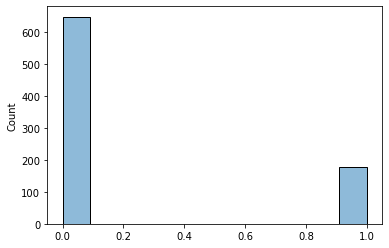

In [23]:
dimension = 2
simmetry = 'p4'
score = 'isotropy'
if os.getcwd().split('\\')[2] == 'lucas':
    score_filename = 'E:/Lucas GAN/Dados/4- Scores/RTGA/%sD/%s/%s.csv' %(dimension,simmetry,score)
else:
    score_filename = 'D:/Lucas GAN/Dados/4- Scores/RTGA/%sD/%s/%s.csv' %(dimension,simmetry,score)

data = np.loadtxt(score_filename,delimiter=',')
X = data[:,1:-1]
size = int(np.sqrt(X.shape[1]))
X = X.reshape((X.shape[0],size,size,1))

y = data[:,-1]
y = y.reshape((y.shape[0],1))

scaler = MinMaxScaler()
y = scaler.fit_transform(y).round(10)
cutoff = 0.85
idxs_good = np.where(y>cutoff)[0]
idxs_bad = np.where(y<=cutoff)[0]

y = np.zeros(y.shape)
y[idxs_good] = 1.0
print(f"Good = %.2f %%"%(100*len(idxs_good)/(len(idxs_good)+len(idxs_bad))))
sns.histplot(y,legend=False);

X_good = X[idxs_good]

input_G = 128
output_G = input_D = X.shape[1:]
output_D = 1

# Models definition

## Generator

In [24]:
def setup_G(input_G,output_G,size):
    size = int(size/2)
    in_G = Input(shape=(input_G,))

    # foundation for 7x7 image
    n_nodes = 128 * size * size
    out_G = Dense(n_nodes,activation=LeakyReLU(alpha=0.2))(in_G)
    out_G = Reshape((size, size, 128))(out_G)
    # upsample to 14x14
    out_G = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same',activation=LeakyReLU(alpha=0.2))(out_G)
    out_G = Conv2D(1, (size,size), activation='sigmoid', padding='same')(out_G)


    out_density = Lambda(lambda x:x)(out_G)

    model = Model(name='Generator',inputs=in_G,outputs=[out_G,out_density])

    return model
setup_G(input_G,output_G,size).summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 1)         8193      
                                                                 
 lambda (Lambda)             (None, 16, 16, 1)         0         
                                                         

## Discriminator

In [25]:
def style_loss(alpha):
    def custom_loss(y_true,y_pred):
#         y_pred = tf.reshape(y_pred,shape=(y_pred.shape[0],y_pred.shape[1]*y_pred.shape[2]))
#         y_true = tf.reshape(y_true,shape=(y_true.shape[0],y_true.shape[1]*y_true.shape[2]))
        size = y_pred.shape[1]*y_pred.shape[2]
        por_true = K.sum(K.sum(K.sum(y_true,axis=1),axis=1),axis=1)/size
        por_pred = K.sum(K.sum(K.sum(y_pred,axis=1),axis=1),axis=1)/size
        mse = MeanSquaredError()
        return alpha*mse(por_true,por_pred)
    return custom_loss

def setup_D(input_D,alpha):
    in_D = Input(shape=input_D)
    out_D = Conv2D(64, (3,3), strides=(2, 2), padding='same', activation=LeakyReLU(alpha=0.2))(in_D)
    out_D = Dropout(0.4)(out_D)
    out_D = Conv2D(64, (3,3), strides=(2, 2), padding='same', activation=LeakyReLU(alpha=0.2))(out_D)
    out_D = Dropout(0.4)(out_D)
    out_D = Flatten()(out_D)
    out_D = Dense(1, activation='sigmoid')(out_D)

    # compile model
    opt = adam_v2.Adam(learning_rate=0.0002, beta_1=0.5)
    
    in_density = Input(shape=input_D)
    out_density = Lambda(lambda x: x)(in_density)

    optimizer = adam_v2.Adam(learning_rate=0.0001, beta_1=0.5)
    model = Model(name='Discriminator',inputs=[in_D,in_density],outputs=[out_D,out_density])

    model.compile(loss=['binary_crossentropy',style_loss(alpha)], optimizer=optimizer, metrics=['accuracy'])
    return model

setup_D(input_D,0.03).summary()

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 16, 16, 1)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     640         ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 8, 8, 64)     0           ['conv2d_1[0][0]']               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 4, 4, 64)     36928       ['dropout[0][0]']                
                                                                                      

## Setup GAN

In [26]:
def setup_GAN(G_model,D_model,alpha,lr,size):
    optimizer = adam_v2.Adam(learning_rate=lr, beta_1=0.5)
    D_model.trainable = False
    in_G = G_model.input
    out_GAN = D_model(G_model(in_G))
    model = Model(name='GAN',inputs=in_G,outputs=out_GAN)
    model.compile(loss=['binary_crossentropy',style_loss(alpha)], \
               optimizer=optimizer, \
               metrics=['accuracy'])
    return model

alpha = 0.03
lr = 2e-4
setup_GAN(setup_G(input_G,output_G,size),setup_D(input_D,alpha),alpha,lr,size).summary()

Model: "GAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 Generator (Functional)         [(None, 16, 16, 1),  1327233     ['input_4[0][0]']                
                                 (None, 16, 16, 1)]                                               
                                                                                                  
 Discriminator (Functional)     [(None, 1),          38593       ['Generator[0][0]',              
                                 (None, 16, 16, 1)]               'Generator[0][1]']              
                                                                                                

# Defining auxiliary functions

In [27]:
def generate_fake_samples(G_model, input_G, n_samples):
    # generate points in latent space
    X_input = generate_input_G(input_G, n_samples)
    # predict outputs
    X,_ = G_model.predict(X_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X,y

def generate_input_G(input_G, n_samples):
    # generate points in the latent space
    X_input = np.random.randn(input_G * n_samples)
    # reshape into a batch of inputs for the network
    X_input = X_input.reshape(n_samples, input_G)
    return X_input

def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

>1, 1/2, D_loss=0.699, G_loss=0.660
>1, 2/2, D_loss=0.705, G_loss=0.655
>2, 1/2, D_loss=0.682, G_loss=0.670
>2, 2/2, D_loss=0.701, G_loss=0.666
>3, 1/2, D_loss=0.687, G_loss=0.659
>3, 2/2, D_loss=0.688, G_loss=0.658
>4, 1/2, D_loss=0.698, G_loss=0.679
>4, 2/2, D_loss=0.696, G_loss=0.689
>5, 1/2, D_loss=0.691, G_loss=0.671
>5, 2/2, D_loss=0.691, G_loss=0.674
>6, 1/2, D_loss=0.687, G_loss=0.675
>6, 2/2, D_loss=0.681, G_loss=0.683
>7, 1/2, D_loss=0.682, G_loss=0.697
>7, 2/2, D_loss=0.690, G_loss=0.693
>8, 1/2, D_loss=0.673, G_loss=0.681
>8, 2/2, D_loss=0.689, G_loss=0.701
>9, 1/2, D_loss=0.681, G_loss=0.692
>9, 2/2, D_loss=0.687, G_loss=0.706
>10, 1/2, D_loss=0.682, G_loss=0.704
>10, 2/2, D_loss=0.679, G_loss=0.698
>11, 1/2, D_loss=0.683, G_loss=0.705
>11, 2/2, D_loss=0.678, G_loss=0.717
>12, 1/2, D_loss=0.669, G_loss=0.697
>12, 2/2, D_loss=0.677, G_loss=0.697
>13, 1/2, D_loss=0.677, G_loss=0.722
>13, 2/2, D_loss=0.670, G_loss=0.698
>14, 1/2, D_loss=0.682, G_loss=0.697
>14, 2/2, D_loss=0.

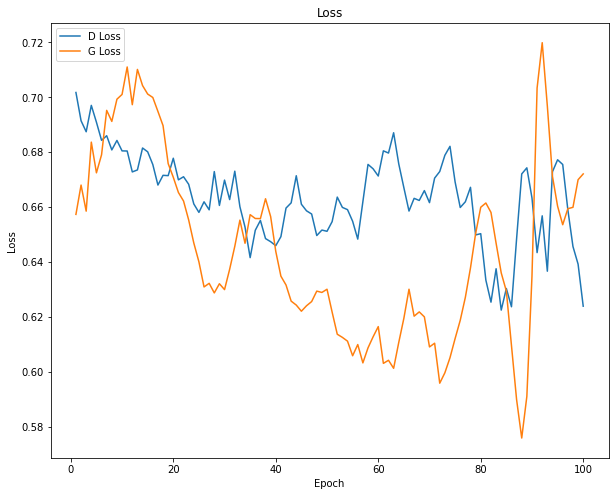

In [39]:
batch_size = 64
num_epochs = 100

alpha = 1e-2
lr = 1e-4
porosity = 0.5

G = setup_G(input_G,output_G,size)
D = setup_D(input_D,alpha)
GAN = setup_GAN(G,D,alpha,lr,size)

def train(G_model,D_model,GAN_model,alpha,lr,porosity,batch_size,num_epochs,plot=False):
    batch_per_epoch = int(X_good.shape[0] /batch_size)
    half_batch = int(batch_size/2)

    G_losses = []
    D_losses = []

    for i in range(num_epochs):
        G_losses_epoch = []
        D_losses_epoch = []
        for j in range(batch_per_epoch):
            X_real,y_real = generate_real_samples(X_good,half_batch)
            X_fake,y_fake = generate_fake_samples(G_model,input_G,half_batch)            

            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
        
            D_loss = D_model.train_on_batch(x=[X,X], y=[y,porosity*np.ones(X.shape)])
            D_loss = D_loss[0]
            D_losses_epoch.append(D_loss)
            
            X_GAN = generate_input_G(input_G, batch_size)
            y_GAN = np.ones((batch_size, 1))
            G_loss= GAN_model.train_on_batch(x=X_GAN, y=[y_GAN,porosity*np.ones(X.shape)])
            G_loss = G_loss[0]
            G_losses_epoch.append(G_loss)

            print('>%d, %d/%d, D_loss=%.3f, G_loss=%.3f' % (i+1, j+1, batch_per_epoch,  D_loss, G_loss))
        
        G_losses.append(G_losses_epoch)
        D_losses.append(D_losses_epoch)
        
        if i == 95:
            G_best = G_model

    G_losses = np.array(G_losses)
    D_losses = np.array(D_losses)

    if plot:
        fig = plt.figure()
        fig.set_size_inches((10,8)) 
        plt.plot(list(range(1,num_epochs+1)),np.mean(D_losses,axis=1),label='D Loss')
        plt.title('Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.plot(list(range(1,num_epochs+1)),np.mean(G_losses,axis=1),label='G Loss')
        plt.legend()
        plt.show()
        
    return G_best

G_best = train(G,D,GAN,alpha,lr,porosity,batch_size,num_epochs,True)


# Training GAN

# Test

0.0


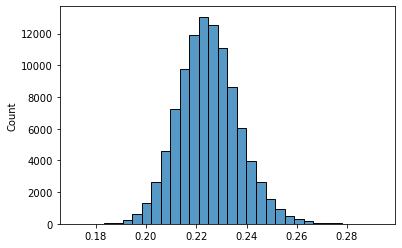

In [42]:
# G = keras.models.load_model("""C:/Users/lucas.barbosa/Documents/GitHub/INT/Manufatura Aditiva/Simulacao-GAN/Pipeline/4- Machine_learning/GAN/models/isotropy_epoch_100_loss_0.7585.h5""")
test_size = 100000
X_test = generate_input_G(input_G,test_size)

generated_geoms,_ = G_best.predict(X_test)

porosities =  []
pors = []

for generated_geom in generated_geoms:
    p = generated_geom.ravel().round().sum()/(size*size)
    if p <= 0.52 and p >= 0.48:
        pors.append(p)
    porosities.append(p)

sns.histplot(porosities,bins=32);
print(100*len(pors)/len(porosities))

## Evaluate `Generator`

Score: 0.60 Porosity: 0.52


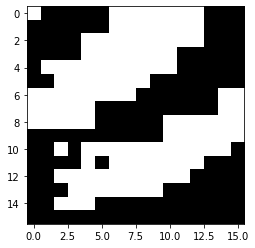

Score: 0.60 Porosity: 0.48


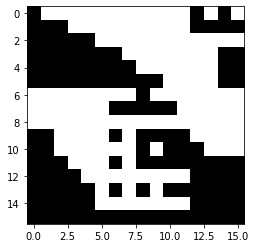

Score: 0.60 Porosity: 0.48


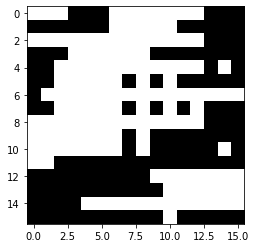

Score: 0.60 Porosity: 0.47


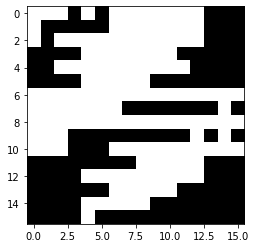

Score: 0.60 Porosity: 0.47


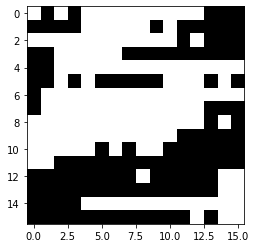

Score: 0.60 Porosity: 0.47


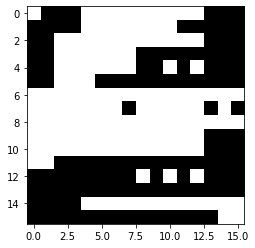

Score: 0.60 Porosity: 0.50


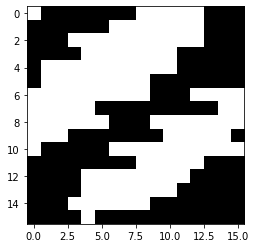

Score: 0.60 Porosity: 0.47


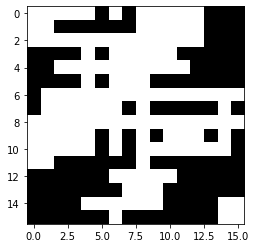

Score: 0.60 Porosity: 0.52


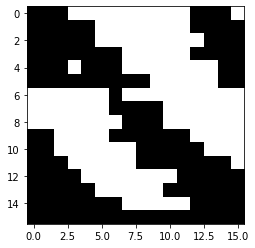

Score: 0.61 Porosity: 0.48


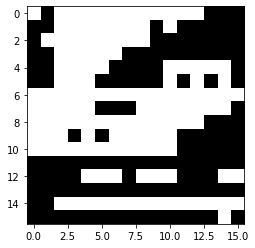

Score: 0.61 Porosity: 0.46


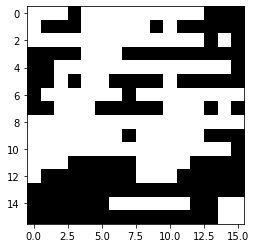

Score: 0.61 Porosity: 0.46


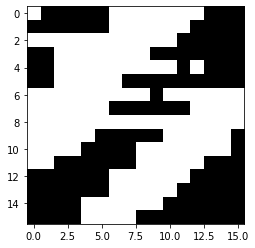

Score: 0.61 Porosity: 0.54


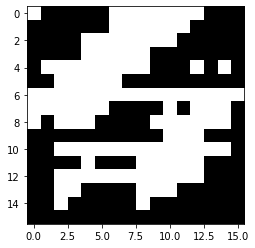

Score: 0.61 Porosity: 0.47


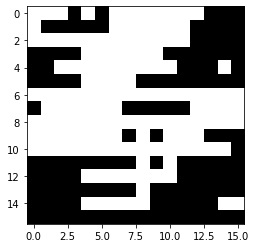

Score: 0.61 Porosity: 0.49


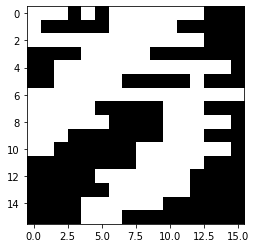

Score: 0.61 Porosity: 0.47


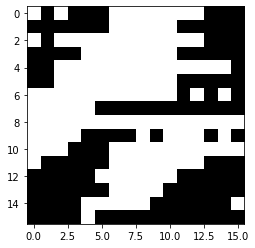

Score: 0.61 Porosity: 0.51


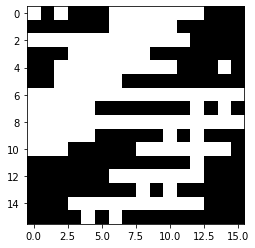

Score: 0.61 Porosity: 0.48


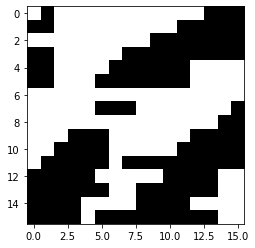

Score: 0.62 Porosity: 0.49


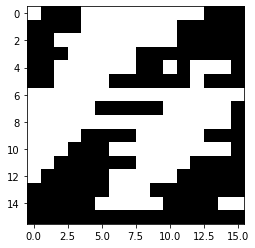

Score: 0.62 Porosity: 0.49


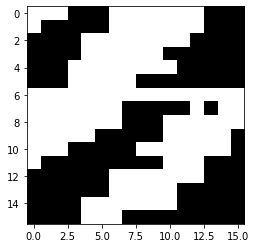

In [32]:
test_size = 1000
X_test = generate_input_G(input_G,test_size)

generated_geoms,_ = G.predict(X_test)

# Filter per porosity
def porosity_match(geoms,porosity,tol):
    geoms_ = []
    passed = 0
    for i in range(geoms.shape[0]):
        g =geoms[i,:,:,0]
        size = g.shape[0]
        g = g.reshape((size*size,))
        p = np.sum(g)/(size*size)
        if p >= (1.0-tol)*porosity and p <= (1.0+tol)*porosity:
            geoms_.append(g.reshape((size,size)))
            passed += 1
    return np.array(geoms_).reshape((passed,size,size,1))

def create_unit(element,size,simmetry):
  if simmetry == 'p4':
    unit_size = 2*size
    fold_size = np.random.choice(4,1)[0]
    unit = np.ones((unit_size,unit_size))*(-1)
    h,w = element.shape
    for i in range(h):
      for j in range(w):
        el = element[i,j]
        i_ = i+size*(fold_size//2)
        j_ = j+size*(fold_size%2)
        unit[i_,j_] = el
        for k in [i_,2*size-1-i_]:
          for l in [j_,2*size-1-j_]:
            unit[k,l] = el
    
  return unit

def check_geometry(geometry,tol,size,simmetry):
  unit = create_unit(geometry,size,simmetry)
  unit_size = 2*size
  labels = measure.label(unit,connectivity=1)
  main_label = 0
  main_label_count = 0
  for label in range(1,len(np.unique(labels))):
    label_count = np.where(labels==label)[0].shape[0]
    if label_count > main_label_count:
      main_label = label
      main_label_count = label_count

  if np.where(labels==0)[0].shape[0]+np.where(labels==main_label)[0].shape[0] >(1.0-tol)*unit_size*unit_size:
    for label in range(1,len(np.unique(labels))):
      if label not in [0,main_label]:
        unit[np.where(labels==label)] = 0.

    if unit[0,:].sum() > 0 and unit[:,0].sum() > 0:
      return True, unit[:size,:size]

    else:
      return False,unit

  else:
    return False, unit

porosity=0.5
tol = 0.1
simmetry = 'p4'
geometries = porosity_match(generated_geoms,porosity,tol)
size = geometries.shape[1]
geometries_ = []

for i in range(geometries.shape[0]):
  geom = geometries[i].reshape((size,size))
  passed,geom_ = check_geometry(geom,tol,size,simmetry)
  if passed:
    geometries_.append(geom_)

geometries = np.array(geometries_).reshape((len(geometries_),size,size,1))
# Round pixels
geometries = geometries.round()

# Get scores
top = 20
scores = D.predict([geometries,geometries])[0]
top_idxs = scores[:,0].argsort()[-top:]

# Add solid boundary
geometries_expanded = []
for i in range(geometries.shape[0]):
    geom = geometries[i]    
    geometries_expanded.append(geom)

geometries = np.array(geometries_expanded).reshape((geometries.shape[0],geometries.shape[1],geometries.shape[2],geometries.shape[3]))

for top_idx in top_idxs:
    geom = geometries[top_idx]
    unit = create_unit(geom.reshape((size,size)),size,simmetry)
    print("Score: %.2f Porosity: %.2f"%(scores[top_idx,0],geom.ravel().sum()/(size*size)))
    plt.imshow(geom,cmap="Greys")
    plt.show()

# sns.histplot(np.sum(generated_geoms.round().reshape((test_size,int(size*size))),axis=-1)/int(size*size),bins=32);